In [15]:
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import string
import re
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses

In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file("aclImdb_v1",url,untar=True,cache_dir='.',cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset),'aclImdb')

84125825/84125825 [==============================] - 5s 0us/step


In [3]:
os.listdir(dataset_dir)

['imdb.vocab', 'test', 'imdbEr.txt', 'README', 'train']

In [4]:
train_dir = os.path.join(dataset_dir,'train')
os.listdir(train_dir)

['urls_neg.txt',
 'urls_pos.txt',
 'unsupBow.feat',
 'labeledBow.feat',
 'pos',
 'urls_unsup.txt',
 'unsup',
 'neg']

In [5]:
from posix import remove
remove_dir = os.path.join(train_dir,'unsup')
shutil.rmtree(remove_dir)

In [6]:
os.listdir(train_dir)

['urls_neg.txt',
 'urls_pos.txt',
 'unsupBow.feat',
 'labeledBow.feat',
 'pos',
 'urls_unsup.txt',
 'neg']

In [7]:
sample_file = os.path.join(train_dir,'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [8]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [10]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(5):
    print("Recenzja", text_batch.numpy()[i])
    print("Etykieta", label_batch.numpy()[i])

Recenzja b"Having seen most of Ringo Lam's films, I can say that this is his best film to date, and the most unusual. It's a ancient china period piece cranked full of kick-ass martial arts, where the location of an underground lair full of traps and dungeons plays as big a part as any of the characters. The action is fantastic, the story is tense and entertaining, and the set design is truely memorable. Sadly, Burning Paradise has not been made available on DVD and vhs is next-to-impossible to get your mitts on, even if you near the second biggest china-town in North America (like I do). If you can find it, don't pass it up."
Etykieta 1
Recenzja b'Caution: May contain spoilers...<br /><br />I\'ve seen this movie 3 times & I\'ve liked it every time. Upon seeing it again, I\'m always reminded of how good it is. An HBO TV movie- very well done like most of their movies are- this would\'ve gotten Oscars for it\'s performances had it been released for general distribution instead of made f

In [12]:
print(f'Etykieta 0 to {raw_train_ds.class_names[0]}')
print(f'Etykieta 1 to {raw_train_ds.class_names[1]}')

Etykieta 0 to neg
Etykieta 1 to pos


In [13]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [14]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size
)

Found 25000 files belonging to 2 classes.


In [16]:
#standardyzacja danych tekstowych
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase,'<br />', ' ')
  return tf.strings.regex_replace(stripped_html,'[%s]' % re.escape(string.punctuation),'')

In [17]:
#wektoryzacja tekstu
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [18]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [19]:
def vectorize_text(text,label):
  text = tf.expand_dims(text,-1)
  return vectorize_layer(text), label

In [20]:
text_batch,label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Recenzja", first_review)
print("Etykieta", first_label)
print("Widok zwektoryzowany", vectorize_text(first_review,first_label))

Recenzja tf.Tensor(b'Belmondo is a tough cop. He goes after a big-time drug dealer (played by Henry Silva, normally a great villain - see "Sharky\'s Machine"; but here he is clearly dubbed, and because of that he lacks his usual charisma). He goes to the scuzziest places of Paris and Marseilles, asks for some names, beats up some people, gets the names, goes to more scuzzy places, asks for more names, beats up more people, etc. The whole movie is punch after punch after punch. It seems that the people who made it had no other ambition than to create the French equivalent of "Dirty Harry". Belmondo, who was 50 here, does perform some good stunts at the beginning; apart from those, "Le Marginal" is a violent, episodic, trite, shallow and forgettable cop movie. (*1/2)', shape=(), dtype=string)
Etykieta tf.Tensor(0, shape=(), dtype=int32)
Widok zwektoryzowany (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[   1,    7,    4, 1233, 1021,   27,  261,  101,    4,    1, 1525,
        6

In [23]:
print(f'15 --> {vectorize_layer.get_vocabulary()[15]}')
print(f'2056 --> {vectorize_layer.get_vocabulary()[2056]}')
print(f'313 --> {vectorize_layer.get_vocabulary()[313]}')
print(f'7 --> {vectorize_layer.get_vocabulary()[7]}')
print(f'1287 --> {vectorize_layer.get_vocabulary()[1287]}')
print(f'Vocabulary size: {len(vectorize_layer.get_vocabulary())}')

15 --> for
2056 --> shallow
313 --> night
7 --> is
1287 --> silent
Vocabulary size: 10000


In [24]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [25]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [26]:
#tworzenie modelu
embedding_dim = 16

model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160033 (625.13 KB)
Trainable params: 160033 (625.13 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [27]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [28]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
625/625 [==============================] - 14s 20ms/step - loss: 0.6647 - binary_accuracy: 0.6891 - val_loss: 0.6167 - val_binary_accuracy: 0.7732
Epoch 2/10
625/625 [==============================] - 6s 10ms/step - loss: 0.5508 - binary_accuracy: 0.7990 - val_loss: 0.5004 - val_binary_accuracy: 0.8198
Epoch 3/10
625/625 [==============================] - 5s 8ms/step - loss: 0.4472 - binary_accuracy: 0.8425 - val_loss: 0.4220 - val_binary_accuracy: 0.8462
Epoch 4/10
625/625 [==============================] - 6s 10ms/step - loss: 0.3799 - binary_accuracy: 0.8642 - val_loss: 0.3749 - val_binary_accuracy: 0.8590
Epoch 5/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3359 - binary_accuracy: 0.8788 - val_loss: 0.3459 - val_binary_accuracy: 0.8672
Epoch 6/10
625/625 [==============================] - 6s 10ms/step - loss: 0.3056 - binary_accuracy: 0.8879 - val_loss: 0.3269 - val_binary_accuracy: 0.8708
Epoch 7/10
625/625 [==============================] - 5s 8m

In [29]:
loss,accuracy = model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 13s 16ms/step - loss: 0.3100 - binary_accuracy: 0.8739
Loss:  0.31003129482269287
Accuracy:  0.8738800287246704


In [30]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

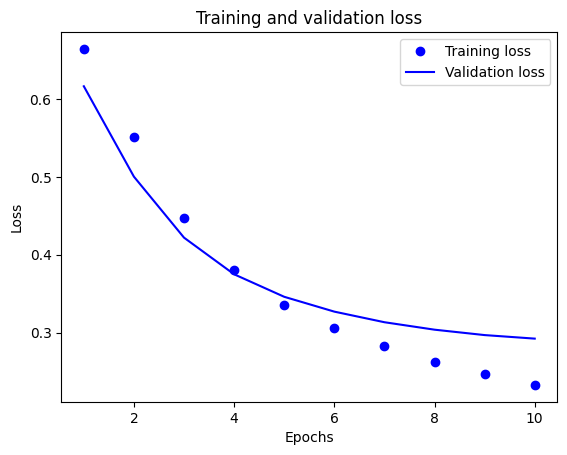

In [31]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [32]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy']
)

loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 7s 8ms/step - loss: 0.3100 - accuracy: 0.8739
0.8738800287246704


In [35]:
testy = [
    "The movie was great!",
    "The movie was okay.",
    "The movie was terrible.",
    "Very bad movie!",
    "Big Shit!",
    "Disaster.",
    "Beautiful disaster",
    "Głupi film.",
    "Głupie filmidło.",
    "The movie was bad bad bad bad bad bad",
    "The movie was okay okay okay okay okay okay okay okay.",
    "Great Great Great Great Great Great Great",
    "The movie was good with good acting but a poor screenplay."
]

In [36]:
export_model.predict(testy)

1/1 [==============================] - 0s 39ms/step


array([[0.6514087 ],
       [0.47893748],
       [0.3929926 ],
       [0.4484828 ],
       [0.56215286],
       [0.49447408],
       [0.58612734],
       [0.5557659 ],
       [0.545302  ],
       [0.0375936 ],
       [0.15630852],
       [0.9728522 ],
       [0.3694067 ]], dtype=float32)